### Análisis EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
path = '../data/processed/datasets_merged.xlsx'
df = pd.read_excel(path)
df.head(10)

,producto,medida_cantidad,medida_unidad,supermercado,costo,anio,mes
0,Babilla (Carne de res de Primera),1.0,Kilogramos,CASA DE LA CARNE CANGREJO,6.40,2020,2
1,Babilla (Carne de res de Primera),1.0,Kilogramos,REY DE VIA ESPAÑA,6.55,2020,2
2,Babilla (Carne de res de Primera),1.0,Kilogramos,RIBA SMITH BELLA VISTA,6.55,2020,2
3,Babilla (Carne de res de Primera),1.0,Kilogramos,RIBA SMITH TRANSISTMICA,6.55,2020,2
4,Babilla (Carne de res de Primera),1.0,Kilogramos,BELLA VISTA,6.51,2020,2
5,Babilla (Carne de res de Primera),1.0,Kilogramos,SUPER 99 CAMINO REAL,6.40,2020,2
6,Babilla (Carne de res de Primera),1.0,Kilogramos,SUPER 99 EL DORADO,6.40,2020,2
7,Babilla (Carne de res de Primera),1.0,Kilogramos,SUPER 99 TUMBA MUERTO,6.40,2020,2
8,Babilla (Carne de res de Primera),1.0,Kilogramos,XTRA TUMBA MUERTO,5.97,2020,2
9,Babilla (Carne de res de Primera),1.0,Kilogramos,BETHANIA,6.29,2020,2


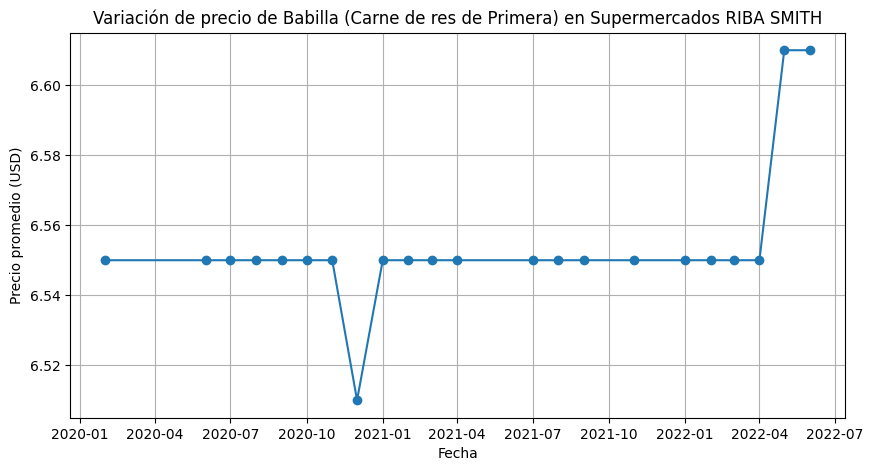

In [9]:

# Filtrar el dataframe para el producto y supermercado deseado
df_babilla = df[(df['producto'] == 'Babilla (Carne de res de Primera)') & 
                (df['supermercado'].str.contains('RIBA SMITH'))]

# Agrupar por año y mes, calcular el precio promedio
df_babilla_grouped = df_babilla.groupby(['anio', 'mes'])['costo'].mean().reset_index()

# Crear columna de fecha
df_babilla_grouped['fecha'] = pd.to_datetime(df_babilla_grouped['anio'].astype(str) + '-' + df_babilla_grouped['mes'].astype(str))

# Graficar la serie de tiempo
plt.figure(figsize=(10, 5))
plt.plot(df_babilla_grouped['fecha'], df_babilla_grouped['costo'], marker='o')
plt.title('Variación de precio de Babilla (Carne de res de Primera) en Supermercados RIBA SMITH')
plt.xlabel('Fecha')
plt.ylabel('Precio promedio (USD)')
plt.grid(True)
plt.show()

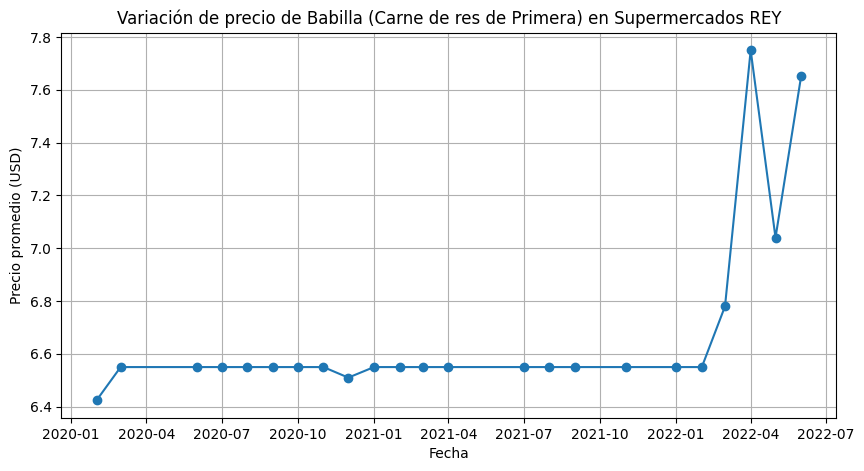

In [8]:


# Filtrar el dataframe para el producto y supermercado deseado
df_babilla = df[(df['producto'] == 'Babilla (Carne de res de Primera)') & 
                (df['supermercado'].str.contains('REY'))]

# Agrupar por año y mes, calcular el precio promedio
df_babilla_grouped = df_babilla.groupby(['anio', 'mes'])['costo'].mean().reset_index()

# Crear columna de fecha
df_babilla_grouped['fecha'] = pd.to_datetime(df_babilla_grouped['anio'].astype(str) + '-' + df_babilla_grouped['mes'].astype(str))

# Graficar la serie de tiempo
plt.figure(figsize=(10, 5))
plt.plot(df_babilla_grouped['fecha'], df_babilla_grouped['costo'], marker='o')
plt.title('Variación de precio de Babilla (Carne de res de Primera) en Supermercados REY')
plt.xlabel('Fecha')
plt.ylabel('Precio promedio (USD)')
plt.grid(True)
plt.show()